In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual, FloatSlider, Dropdown, GridspecLayout, Checkbox
from IPython.display import HTML, display

from matplotlib.animation import FuncAnimation, PillowWriter
import scipy.linalg as la
from matplotlib.patches import Polygon
import matplotlib.transforms as transforms
import matplotlib.patches as patches

from NumericalMethods import *



In [7]:
def naca_airfoil4(max_camber, camber_position, thickness, num_points=100, length=1, centrepos=0.5):
    """
    Generates a 4-digit NACA airfoil based on the given parameters, with variable length and centering position.

    Using Wikipedia's parameterization for a 4-digit NACA airfoil for symmetric airfoils, and NACA's original equations for cambered airfoils.

    Parameters:
    max_camber (float): Maximum camber as a percentage of the chord (0 to 9.9).
    camber_position (float): Position of maximum camber as a fraction of the chord (0 to 0.9).
    thickness (float): Maximum thickness as a percentage of the chord (0 to 40).
    num_points (int): Number of points to generate for the airfoil (default: 100).
    length (float): Length of the airfoil (chord length). Defaults to 1.
    centrepos (float): Position along the chord at which the airfoil will be centered (0 to 1).

    Returns:
    numpy.ndarray: Array of airfoil coordinates with columns for x and y coordinates.
    """
    # Convert max_camber and thickness to decimals
    m = max_camber / 100
    p = camber_position / 10
    t = thickness / 100
    
    # Generate x-coordinates with cosine spacing
    beta = np.linspace(0, np.pi, num_points)
    x = 0.5 * (1 - np.cos(beta))
    
    # Initialize y-coordinates for camber line (yc) and thickness distribution (yt)
    yc = np.zeros_like(x)
    dyc_dx = np.zeros_like(x)
    yt = 5 * t * (0.2969 * np.sqrt(x) - 0.1260 * x - 0.3516 * x**2 + 0.2843 * x**3 - 0.1015 * x**4)
    
    # Compute yc and dyc_dx based on the position of maximum camber (p)
    for i in range(num_points):
        if x[i] < p:
            yc[i] = (m / p**2) * (2 * p * x[i] - x[i]**2)
            dyc_dx[i] = (2 * m / p**2) * (p - x[i])
        else:
            yc[i] = (m / (1 - p)**2) * ((1 - 2 * p) + 2 * p * x[i] - x[i]**2)
            dyc_dx[i] = (2 * m / (1 - p)**2) * (p - x[i])
    
    # Calculate the angle (theta) for each point
    theta = np.arctan(dyc_dx)
    
    # Calculate upper and lower surface coordinates
    xu = x - yt * np.sin(theta)
    yu = yc + yt * np.cos(theta)
    xl = x + yt * np.sin(theta)
    yl = yc - yt * np.cos(theta)
    
    # Combine upper and lower surface points; start at trailing edge and move along upper surface
    # back to the leading edge, then along the lower surface to form a closed loop
    x_coords = np.concatenate([xu[::-1], xl[1:]])
    y_coords = np.concatenate([yu[::-1], yl[1:]])
    
    # Scale by the length parameter, then center along the chord
    x_coords *= length
    y_coords *= length
    x_coords -= centrepos * length
    
    # Return as a two-column array
    airfoil_coords = np.column_stack((x_coords, y_coords))
    
    return airfoil_coords

def coupled_flutter_response(mu,sigma,r2, a,reduced_vel,mode = 'Steady'):
    """
    Compute the flutter response of a coupled system with the given parameters.

    Parameters:
    mu (float): Mass ratio.
    sigma (float): Stiffness ratio.
    r2 (float): Damping ratio.
    a (float): Torsional Axis Location.
    reduced_vel (float): Reduced velocity.
    mode (string): Approximation Chosen for Aerodynamic Influence Matrix; 'Steady', 'Unsteady', 'Quasi-Steady' or 'kussner'. - kussner stc

    Returns:
    Eigen Value Problem Solution: Eigenvalues and Eigenvectors.
    """

    # Define non-dimensional parameters
    e_default = 0.5  # Default eccentricity - center of mass location from leading edge
    x_theta = e_default - a  # Static unbalance
    #x_theta = 0 # No static unbalance


    # Mass and stiffness matrices
    M = np.array([[1, x_theta],
                  [x_theta, r2]])
    K = np.array([[sigma**2 / reduced_vel**2, 0],
                  [0, r2 / reduced_vel**2]])
    
    # Aerodynamic influence matrix based on selected mode
    if mode == 'Steady':
        F = np.array([[0, -2 * np.pi],
                      [0, -2 * np.pi * (a + 0.5)]])
    elif mode == 'Quasi-Steady':
        # Including velocity terms for quasi-steady behavior
        F = np.array([[np.pi, 2 * np.pi * reduced_vel],
                      [np.pi * x_theta, 2 * np.pi * (reduced_vel + 0.5)]])
    else:
        raise ValueError("Unknown mode type. Use 'Steady' or 'Quasi-Steady'.")
    
    # Construct the system matrix
    A = np.block([
        [np.zeros_like(M), np.eye(2)],
        [-la.inv(M) @ (K - F), np.zeros_like(M)]
    ])

    print(A)
    
    # Compute eigenvalues
    eigvals, eigvecs = la.eig(A)
    
    return eigvals, eigvecs


def animate_flutter(airfoil_coords,mu, sigma, r2, a, reduced_velocity, mode='Steady', scale = 0.1, duration=10, fps=30, properties = {'airfoil_color': 'lightblue','transparency': 50,'angled_lines' : True, 'angled_text' : True, 'annotated_text_color' : 'black', 'show_chord' : True}):
    """
    Animate the flutter response of a coupled system with the given parameters.

    Additional Parameters:
    airfoil_coords (numpy.ndarray): Array of airfoil coordinates with columns for x and y coordinates.
    scale (float): Scaling factor for the animation (default: 0.1).
    duration (float): Duration of the animation in seconds (default: 10).
    fps (int): Frames per second for the animation (default: 30).
    properties (dict): Dictionary of properties for the animation.
        properties['airfoil_color'] (str): Color for the airfoil shape (default: 'lightblue').
        properties['angled_lines'] (bool): Whether to include angled lines for reference (default: True).
        properties['angled_text'] (bool): Whether to include annotated text for the displacement angle (default: True).
        properties['annotated_text_color'] (str): Color for the annotated text (default: 'black').
        properties['show_chord'] (bool): Whether to show the chord length on the plot (default: False).

    Returns:
    HTML: Animation of the flutter response.
    XX: Animation of amplitude and phase of plunge and twist components over time.
    XX: Animation of displacement history of the airfoil for a given reduced velocity.

    """
    eigvals, eigvecs = coupled_flutter_response(mu, sigma, r2, a, reduced_velocity, mode)
    
    # Extract relevant eigenvalues for flutter
    real_parts = np.real(eigvals)
    imag_parts = np.imag(eigvals)

    
    fig, ax = plt.subplots()
    t = np.linspace(0, duration, duration * fps)

    # Calculate values of interest
    airfoil_length = np.max(airfoil_coords[:, 0]) - np.min(airfoil_coords[:, 0])
    alpha = properties['transparency'] / 100

    
    # Plot setup
    airfoil_patch = Polygon(airfoil_coords, closed=True, edgecolor='k', facecolor=properties['airfoil_color'], alpha=alpha)

    ax.add_patch(airfoil_patch)
    ax.set_xlim(-2*airfoil_length, 2*airfoil_length)
    ax.set_ylim(-2 * airfoil_length, 2 * airfoil_length)
    
    ax.set_aspect('equal')
    ax.set_title(f"Coupled Flutter Animation ({mode})")
    ax.set_xlabel("Angular Displacement")
    #ax.set_ylabel("Vertical Displacement")

    # ax2 = ax.twinx()
    # ax2.set_ylabel('Displacement Angle (degrees)', color='red')
    # ax2.tick_params(axis='y', labelcolor='red')

    # Adding angled lines for reference at 0, 15, 30, 45, 60 and 90 degrees
    for angle in [0, 15, 30, 45, 60, 75, 90]:
        if angle == 0:
            ax.plot([0, 1], [0, 0], 'k--', alpha=0.5)

            ax.text(1.25 * airfoil_length, 0, f'{angle}°', fontsize=8, ha='center',color='red')
        else:
            ax.plot([0, 1.5*airfoil_length], [0, np.tan(np.radians(angle))], 'k--', alpha=0.2*alpha)
            ax.plot([0, -1.5*airfoil_length], [0, -np.tan(np.radians(angle))], 'k--', alpha=0.2*alpha)
            ax.plot([0, 1.5*airfoil_length], [0, -np.tan(np.radians(angle))], 'k--', alpha=0.2*alpha)
            ax.plot([0, -1.5*airfoil_length], [0, np.tan(np.radians(angle))], 'k--', alpha=0.2*alpha)

            # Calculate the coordinates for the text labels
            x_pos = 1.25 * airfoil_length * np.cos(np.radians(angle))
            y_pos = 1.25 * airfoil_length * np.sin(np.radians(angle))
            x_neg = 1.25 * airfoil_length * np.cos(np.radians(angle))
            y_neg = -1.25 * airfoil_length * np.sin(np.radians(angle))

            ax.text(x_pos, y_pos, f'{angle}°', fontsize=8, ha='center', color='red')
            ax.text(x_neg, y_neg, f'{angle}°', fontsize=8, ha='center', color='red')
            
    if properties['show_chord']:
        # Adding a line for chord length
        ax.plot([-airfoil_length, airfoil_length], [0, 0], '--', color=properties['airfoil_color'], alpha=0.25*alpha)
    
    if properties['angled_text']:
        # Adding an annotation for displacement angle
        angle_text = ax.text(0.98, 0.95, '', transform=ax.transAxes, fontsize=10, color=properties['annotated_text_color'], ha='right')
        vertical_text = ax.text(0.98, 0.90, '', transform=ax.transAxes, fontsize=10, color=properties['annotated_text_color'], ha='right')
        # ax2 = ax.twinx()
        # ax2.set_ylabel('Displacement Angle (degrees)', color='red')
        # ax2.tick_params(axis='y', labelcolor='red')
    
    # Function to update airfoil position for each frame
    def update(frame):
        #h_t = 0 # no plunge
        h_t = np.exp(real_parts[0] * frame) * np.cos(imag_parts[0] * frame)# * scale  # Scale for visibility
        theta_t = np.exp(real_parts[1] * frame) * np.cos(imag_parts[1] * frame)# * scale  # Scale for visibility
        
        # Define transformation: translation + rotation
        trans = transforms.Affine2D().rotate_deg_around(a, 0, np.degrees(theta_t)).translate(0, h_t) + ax.transData
        airfoil_patch.set_transform(trans)

        # transform chord line
        # if properties['show_chord']:
        #     chord_line = ax.lines[-1]
        #     chord_line.set_xdata([-airfoil_length, airfoil_length])
        #     chord_line.set_ydata([0, 0])
        #     chord_line.set_transform
        
        # Update displacement angle text with +XX for positive angles and -XX for negatives
        angle_text.set_text(f'Displacement Angle: {"+" if theta_t >= 0 else "-"}{abs(np.degrees(theta_t)):.2f}°')

        # Update vertical displacement text with +XX for positive displacements and -XX for negatives
        vertical_text.set_text(f'Vertical Displacement: {"+" if h_t >= 0 else "-"}{abs(h_t):.2f}')



        
        return airfoil_patch, angle_text
    
    ani = FuncAnimation(fig, update, frames=t, blit=True, interval=50)
    plt.show()
    return HTML(ani.to_jshtml())

In [8]:
# Define the airfoil parameters
xcm = 0.5 # Centre of mass position from leading edge
xac = 0.5 # Aerodynamic centre position from leading edge

b = .5 # Semi-span
c = 2*b # Chord length or wing span

# Parameters (default values for typical section model)
mu_default = 20  # Mass ratio - m/(rho*pi*b**2)
sigma_default = 0.4  # Frequency ratio - omega_h/omega_theta
r2_default = 0.25  # Radius of gyration squared - r = sqrt(I_theta/m*b**2)
a_default = 0.01#1e-6  # Torsional axis location, small number - cannot be zero otherwise singular matrix, non-invertible
reduced_vel_default = 2  # Reduced velocity - u/(b*omega_theta) 
e_default = -0.1  # Center of mass location

In [9]:
# Airfoil Coordinate Generation
generate_airfoil_widget = interact_manual(
    lambda max_camber, camber_pos, chord_length, thickness, centre_of_mass, airfoil_type: naca_airfoil4(max_camber, camber_pos, thickness, num_points=100, length=chord_length, centrepos=centre_of_mass),
    max_camber=FloatSlider(value=0.0, min=0.0, max=9.9, step=0.5, description='Max Camber'),
    camber_pos=FloatSlider(value=0.0, min=0.0, max=9.9, step=0.5, description='Camber Position'),
    chord_length=FloatSlider(value=1.0, min=0.5, max=5.0, step=0.1, description='Chord Length'),
    thickness=FloatSlider(value=0.1, min=0.05, max=0.5, step=0.01, description='Thickness'),
    centre_of_mass=FloatSlider(value=0.5, min=0.0, max=1.0, step=0.05, description='Centre of Mass'),
    airfoil_type=Dropdown(options=['NACA 0012', 'NACA 2412', 'Custom'], value='NACA 0012', description='Airfoil Type')
)
generate_airfoil_widget.button_style = 'info'
generate_airfoil_widget.widget.children[-2].description = 'Generate Coordinates'

# Todo
# Need to add a way to collate results from widget, and store as a variable or add to tuple airfoil_objects


# Create airfoil objects - Prototyping
airfoil_2412 = naca_airfoil4(2, 4, 12, num_points=100, length=c, centrepos=xcm)
print(airfoil_2412)
airfoil_0010 = naca_airfoil4(0, 0, 10, num_points=100, length=c, centrepos=xcm)


interactive(children=(FloatSlider(value=0.0, description='Max Camber', max=9.9, step=0.5), FloatSlider(value=0…

[[ 0.50008381  0.00125721]
 [ 0.4998344   0.00130923]
 [ 0.49908639  0.00146512]
 [ 0.49784048  0.00172441]
 [ 0.49609786  0.0020863 ]
 [ 0.49386017  0.00254969]
 [ 0.49112951  0.00311317]
 [ 0.48790847  0.00377503]
 [ 0.4842001   0.00453329]
 [ 0.4800079   0.00538567]
 [ 0.47533585  0.00632964]
 [ 0.47018839  0.00736242]
 [ 0.4645704   0.00848099]
 [ 0.45848725  0.00968212]
 [ 0.45194472  0.01096236]
 [ 0.44494909  0.01231809]
 [ 0.43750704  0.0137455 ]
 [ 0.42962573  0.01524064]
 [ 0.42131271  0.01679941]
 [ 0.41257602  0.0184176 ]
 [ 0.40342407  0.02009087]
 [ 0.39386573  0.02181482]
 [ 0.38391026  0.02358493]
 [ 0.37356734  0.02539666]
 [ 0.36284703  0.02724539]
 [ 0.35175978  0.02912646]
 [ 0.34031645  0.03103518]
 [ 0.32852823  0.03296684]
 [ 0.31640669  0.03491672]
 [ 0.30396376  0.03688008]
 [ 0.29121169  0.03885218]
 [ 0.27816307  0.04082829]
 [ 0.26483079  0.04280368]
 [ 0.25122808  0.04477364]
 [ 0.23736843  0.04673345]
 [ 0.22326562  0.04867844]
 [ 0.20893369  0.05060392]
 

[[  0.           0.           1.           0.        ]
 [  0.           0.           0.           1.        ]
 [ -1.01010101   3.02996783   0.           0.        ]
 [  1.97979798 -19.00643496   0.           0.        ]]


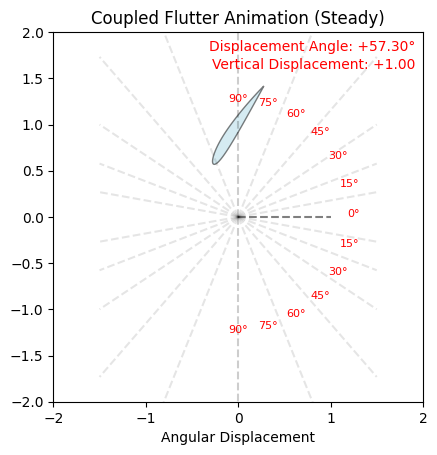

In [ ]:
# Animate airfoil objects
ani_2412 = animate_flutter(airfoil_2412, mu_default, sigma_default, r2_default, a_default, reduced_vel_default, mode='Steady', duration=10, fps=30, properties={'airfoil_color':'lightblue','show_chord' : False, 'transparency': 50, 'angled_lines' : True, 'angled_text' : True, 'annotated_text_color' : 'red'})
ani_0010 = animate_flutter(airfoil_0010, 0.5*mu_default, sigma_default, r2_default, 0.5*a_default, 0.5*reduced_vel_default, mode='Steady', duration=10, fps=30, properties={'airfoil_color':'hotpink','show_chord' : True, 'transparency': 50, 'angled_lines' : True, 'angled_text' : True, 'annotated_text_color' : 'red'})

display(ani_2412)
display(ani_0010)

In [6]:
# Define a grid layout for additional properties (3x3 grid of checkboxes and dropdowns)
def create_property_grid():
    grid = GridspecLayout(3, 3, height='200px')
    
    # First row - visibility toggles
    grid[0, 0] = Checkbox(description='Show Grid', value=True)
    grid[0, 1] = Checkbox(description='Show Axes', value=True)
    grid[0, 2] = Checkbox(description='Show Labels', value=True)
    
    # Second row - color selection
    grid[1, 0] = Dropdown(options=['Red', 'Blue', 'Green'], value='Blue', description='Color 1')
    grid[1, 1] = Dropdown(options=['Red', 'Blue', 'Green'], value='Green', description='Color 2')
    grid[1, 2] = Dropdown(options=['Red', 'Blue', 'Green'], value='Red', description='Color 3')
    
    # Third row - line style selection
    grid[2, 0] = Dropdown(options=['solid', 'dashed', 'dotted'], value='solid', description='Line Style 1')
    grid[2, 1] = Dropdown(options=['solid', 'dashed', 'dotted'], value='dashed', description='Line Style 2')
    grid[2, 2] = Dropdown(options=['solid', 'dashed', 'dotted'], value='dotted', description='Line Style 3')
    
    return grid

# Main animation widget with additional properties grid
animate_airfoil_widget = interact_manual(
    lambda mu, sigma, r2, a, velocity, mode: animate_flutter(mu, sigma, r2, a, velocity, mode),
    mu=FloatSlider(value=10.0, min=5, max=50, step=1, description='Mass Ratio (μ)'),
    sigma=FloatSlider(value=1.0, min=0.1, max=2.0, step=0.05, description='Freq. Ratio (σ)'),
    r2=FloatSlider(value=0.5, min=0.1, max=1.0, step=0.05, description='Radius of Gyration² (r²)'),
    a=FloatSlider(value=0.0, min=-0.5, max=0.5, step=0.05, description='Torsional Axis (a)'),
    velocity=FloatSlider(value=2.0, min=0.5, max=5.0, step=0.1, description='Reduced Velocity (V)'),
    mode=Dropdown(options=['steady', 'quasi-steady', 'unsteady'], value='steady', description='Mode')
)
animate_airfoil_widget.button_style = 'info'
animate_airfoil_widget.widget.children[-2].description = 'Generate Animation'

# Display the properties grid below the main widget
display(create_property_grid())

# Todo
# Need to add a way to use results from airfoil coords widget, to generate the animation and store to a list of animations

interactive(children=(FloatSlider(value=10.0, description='Mass Ratio (μ)', max=50.0, min=5.0, step=1.0), Floa…

GridspecLayout(children=(Checkbox(value=True, description='Show Grid', layout=Layout(grid_area='widget001')), …